# Generative Adversarial Network (GAN)

## Concept

GAN is composed of two neural networks that compete with each other, hence the name adversarial. There's the **Generator** network (G) and **Discriminator** network (D).

### Generator Network

The generator's task is to generate _fake data_ that could, hopefully, fool the discriminator. The generator does not have access to the _real data_ that the discriminator expects, instead it improves its ability to generate fake data by learning what feature of the data is expected by the discriminator.

- Input: vector of **noise**
- Output: fake data with the **same shape** as the real data

Stochastic gradient for generator network:

<center> $\bigtriangledown_{\theta_{d}}\frac{1}{m} \displaystyle\sum_{i=1}^{m}log (1-D(G(z^{(i)})))$ </center>

The target is to **minimize** the value of $1-D(G(z^{(i)}))$ which means **maximizing** the value of $D(G(z^{(i)})$, the probability that the discriminator passes the fake data generated by the generator as real.

### Discriminator Network

The discriminator's task is to determine if a data is _real_ or _fake_. The discriminator is actually updated by **ascending** its stochastic gradient, instead of descending.

- Input: real and fake **data**
- Output: binary (is the data real or fake)

Stochastic gradient for discriminator network:

<center> $\bigtriangledown_{\theta_{d}}\frac{1}{m} \displaystyle\sum_{i=1}^{m}[log D(x^{(i)}) + log (1-D(G(z^{(i)})))]$ </center>

## GAN for MNIST Dataset with Keras

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.models import load_model
from keras.optimizers import Adam

class GAN():
    
    def __init__(self):
        self.img_rows = 28 
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        
        self.noise_shape = (100,)

        # Manually tune down learning rate to avoid oscillation
        optimizer = Adam(lr=0.0002, beta_1=0.5)

        # -------------
        # Discriminator
        # -------------
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='mean_squared_error', 
                                   optimizer=optimizer,
                                   metrics=['accuracy'])
        # ---------
        # Generator
        # ---------
        self.generator = self.build_generator()
        self.generator.compile(loss='mean_squared_error',
                               optimizer=optimizer)
        # --------
        # Combined
        # --------
        # The combined model is created by stacking generator and discriminator.
        # Noise ---Generator--> Generated Image ---Discriminator--> Validity
        
        z = Input(shape=self.noise_shape)
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False
        
        validity = self.discriminator(img)

        self.combined = Model(z, validity)
        self.combined.compile(loss='mean_squared_error',
                              optimizer=optimizer)

        
    def save_models(self, epoch=None):
        if epoch is None:
            self.discriminator.save('gan/models/mnist-discriminator.h5')
            self.generator.save('gan/models/mnist-generator.h5')
            self.combined.save('gan/models/mnist-combined.h5')
        else:
            self.discriminator.save('gan/models/mnist-discriminator-{}.h5'.format(int(epoch)))
            self.generator.save('gan/models/mnist-generator-{}.h5'.format(int(epoch)))
            self.combined.save('gan/models/mnist-combined-{}.h5'.format(int(epoch)))
        
        
    def load_models(self, epoch=None): 
        if epoch is None:
            self.discriminator = load_model('gan/models/mnist-discriminator.h5')
            self.generator = load_model('gan/models/mnist-generator.h5')
            self.combined = load_model('gan/models/mnist-combined.h5')
        else:
            self.discriminator = load_model('gan/models/mnist-discriminator-{}.h5'.format(int(epoch)))
            self.generator = load_model('gan/models/mnist-generator-{}.h5'.format(int(epoch)))
            self.combined = load_model('gan/models/mnist-combined-{}.h5'.format(int(epoch)))
            
        
    def build_discriminator(self):
        model = Sequential()
        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        
        model.summary()

        # Discriminator takes an image as an input and outputs its validity
        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

        
    def build_generator(self):
        # BatchNormalization maintains the mean activation close to 0
        # and the activation standard deviation close to 1
        model = Sequential()
        model.add(Dense(256, input_shape=self.noise_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='sigmoid'))
        model.add(Reshape(self.img_shape))
        
        model.summary()

        # Generator takes noise as an input and outputs an image
        noise = Input(shape=self.noise_shape)
        img = model(noise)

        return Model(noise, img)
    
    
    def train(self, epochs, batch_size=128, export_image_interval=250, save_model_interval=2500):

        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()
        
        # X_train shape: (m, W, H)
        
        # Rescale 0 to 1
        X_train = (X_train.astype(np.float32)) / 255
        
        # Change X_train's shape to (m, W, H, c)
        X_train = np.expand_dims(X_train, axis=3)

        half_batch = int(batch_size / 2)

        for epoch in range(epochs):

            # -------------------
            # Train Discriminator
            # -------------------
            # Select a random half batch of images
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            imgs = X_train[idx]

            # Generate a half batch of new images
            noise = np.random.normal(0, 1, (half_batch, 100))
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------
            # Train Generator
            # ---------------
            noise = np.random.normal(0, 1, (batch_size, 100))

            # The generator wants to fool the discriminator, hence trained with valid label (1)
            valid_y = np.array([1] * batch_size)

            # Train the generator
            g_loss = self.combined.train_on_batch(noise, valid_y)


            # Print progress
            print ("{:5d} [D loss: {}, acc_real: {:2f}, acc_fake: {:2f}] [G loss: {}]".format(epoch, d_loss[0], 100*d_loss_real[1], 100*d_loss_fake[1], g_loss))

            # Save generated samples at export_image_interval
            if epoch % export_image_interval == 0:
                r, c = 3, 3

                fig, axs = plt.subplots(r, c)
                
                prediction = self.discriminator.predict(gen_imgs)
                prediction = np.round(prediction)
                
                fooled_indices = []
                
                for i in range(len(prediction)):
                    if prediction[i] == 1:
                        fooled_indices.append(i)
                
                fooled_count = len(fooled_indices)
                
                # Export generated images that the discriminator classified as real
                cnt = 0
                if (fooled_count > 0):
                    for i in range(r):
                        for j in range(c):
                            # Prevent error where count exceeds the number of failed test case for discriminator
                            if (cnt >= fooled_count):
                                break
                            axs[i,j].imshow(gen_imgs[fooled_indices[cnt], :,:,0], cmap='gray')
                            axs[i,j].axis('off')
                            cnt += 1
                            
                fig.savefig("gan/images/mnist_{}_fooled.png".format(epoch))
                plt.close()
                
                # Export generated images that the discriminator classified as fake
                fig, axs = plt.subplots(r, c)
                success_count = len(prediction) - fooled_count
                cnt = 0
                if (success_count > 0):
                    for i in range(r):
                        for j in range(c):
                            # Find index not in fooled_indices
                            while cnt in fooled_indices:
                                cnt += 1
                                
                            # Prevent error where count exceeds the number of successful test case for discriminator
                            if (cnt >= success_count):
                                break
                            
                            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                            axs[i,j].axis('off')
                            cnt += 1
                fig.savefig("gan/images/mnist_{}_detected.png".format(epoch))
                plt.close()
            
            
            # Save models at save_interval
            if epoch != 0 and epoch % save_model_interval == 0:
                self.save_models(epoch)
                


# if __name__ == '__main__':
#     gan = GAN()
#     gan.train(epochs=30001, batch_size=64, export_image_interval=250, save_model_interval=2500)

Using TensorFlow backend.


### Loading Saved Model

In [2]:
gan125 = GAN()
gan125.load_models(12500)

gan175 = GAN()
gan175.load_models(17500)

gan300 = GAN()
gan300.load_models(30000)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________
____

/home/rionaldichandraseta/miniconda3/envs/gan-image/lib/python3.6/site-packages/keras/engine/saving.py:305: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________
____

### Generate New Data

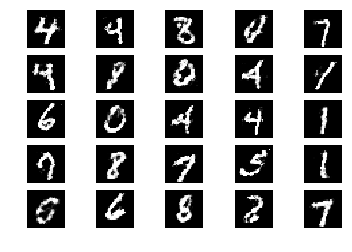

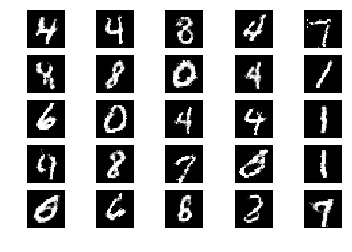

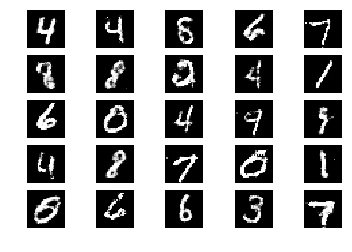

In [3]:
noise = np.random.normal(0, 1, (25, 100))

gen_imgs_125 = gan125.generator.predict(noise)
gen_imgs_175 = gan175.generator.predict(noise)
gen_imgs_300 = gan300.generator.predict(noise)

fig, axs = plt.subplots(5, 5)
count = 0
for i in range(5):
    for j in range(5):
        axs[i,j].imshow(gen_imgs_125[count, :,:,0], cmap='gray')
        axs[i,j].axis('off')
        count += 1
        
fig, axs = plt.subplots(5, 5)
count = 0
for i in range(5):
    for j in range(5):
        axs[i,j].imshow(gen_imgs_175[count, :,:,0], cmap='gray')
        axs[i,j].axis('off')
        count += 1

fig, axs = plt.subplots(5, 5)
count = 0
for i in range(5):
    for j in range(5):
        axs[i,j].imshow(gen_imgs_300[count, :,:,0], cmap='gray')
        axs[i,j].axis('off')
        count += 1

## Build MNIST Classifier

In [5]:
class MNISTClassifier():
    
    def __init__(self):
        self.n_class = 10
        
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        
        adam = Adam(lr=0.001,
                    beta_1=0.9,
                    beta_2=0.999,
                    epsilon=None,
                    decay=0.00001,
                    amsgrad=False)
        
        self.classifier = self.build_classifier()
        self.classifier.compile(optimizer=adam,
                                loss='categorical_crossentropy',
                                metrics=['accuracy'])
        
        
    def build_classifier(self):
        model = Sequential()
        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(392,
                       activation='relu',
                       kernel_initializer='he_uniform'))
        model.add(Dropout(0.2))
        model.add(Dense(196,
                       activation='relu',
                       kernel_initializer='he_uniform'))
        model.add(Dropout(0.2))
        model.add(Dense(98,
                       activation='relu',
                       kernel_initializer='he_uniform'))
        model.add(Dropout(0.1))
        model.add(Dense(self.n_class,
                       activation='softmax',
                       kernel_initializer='glorot_normal'))
        
        model.summary()
        
        return model
    
if __name__ == '__main__':
    classifier = MNISTClassifier()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 392)               307720    
_________________________________________________________________
dropout_1 (Dropout)          (None, 392)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 196)               77028     
_________________________________________________________________
dropout_2 (Dropout)          (None, 196)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 98)                19306     
_________________________________________________________________
dropout_3 (Dropout)          (None, 98)                0         
__________